# 💰 Comparación de Costo Computacional de Modelos ECG

Este notebook compara el costo computacional de los diferentes modelos entrenados:
- **CNN1D**: Modelo base con solo capas convolucionales
- **CNN1D + LSTM**: Modelo híbrido con CNN y LSTM
- **CNN1D + Transformer**: Modelo híbrido con CNN y Transformer

**Métricas medidas:**
- Número de parámetros
- Tamaño del modelo en disco
- Tiempo de inferencia (forward pass)
- Memoria usada durante inferencia
- FLOPs (Floating Point Operations)
- Throughput (muestras/segundo)

**Integración con MLflow:**
- Todas las métricas se registran en MLflow para comparación y tracking


## 📋 Índice

1. **Setup y dependencias** - Imports y configuración
2. **Definiciones de modelos** - Clases de los modelos
3. **Funciones de medición** - Métricas de costo computacional
4. **Carga de modelos** - Cargar modelos guardados
5. **Medición de métricas** - Evaluar cada modelo
6. **Comparación y visualización** - Gráficos comparativos
7. **Registro en MLflow** - Guardar resultados en MLflow


## 1. ⚙️ Setup y Dependencias


In [23]:
import os
import sys
import json
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import mlflow
import mlflow.pytorch
from contextlib import contextmanager

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Dispositivo: {device}")

# Configuración de rutas
PARENT_DIR = Path(__file__).parent if "__file__" in globals() else Path.cwd()
MODELS_DIR = PARENT_DIR / "models"
OUTPUT_DIR = PARENT_DIR / "computational_cost_comparison"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"✓ Directorio de modelos: {MODELS_DIR}")
print(f"✓ Directorio de salida: {OUTPUT_DIR}")


✓ Dispositivo: cuda
✓ Directorio de modelos: s:\Proyecto final\Books\models
✓ Directorio de salida: s:\Proyecto final\Books\computational_cost_comparison


## 2. 🏗️ Definiciones de Modelos


In [24]:
# ========================================
# CNN1D Classifier
# ========================================
class CNN1DClassifier(nn.Module):
    """CNN1D para clasificación binaria de series temporales."""
    
    def __init__(
        self,
        n_channels: int,
        seq_len: int,
        out_channels_list: List[int],
        kernel_sizes: List[int],
        pool_sizes: List[int],
        use_batchnorm: bool = True,
        cnn_activation: str = "relu",
        fc_units: int = 64,
        fc_dropout: float = 0.2,
    ):
        super(CNN1DClassifier, self).__init__()
        
        self.n_channels = n_channels
        self.seq_len = seq_len
        
        # Bloque CNN 1D
        cnn_layers = []
        in_channels = n_channels
        
        for i in range(len(out_channels_list)):
            cnn_layers.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels_list[i],
                    kernel_size=kernel_sizes[i],
                    padding=(kernel_sizes[i] - 1) // 2,
                )
            )
            
            if use_batchnorm:
                cnn_layers.append(nn.BatchNorm1d(out_channels_list[i]))
            
            if cnn_activation.lower() == "relu":
                cnn_layers.append(nn.ReLU())
            elif cnn_activation.lower() == "leakyrelu":
                cnn_layers.append(nn.LeakyReLU(0.1))
            
            if pool_sizes[i] is not None and pool_sizes[i] > 1:
                cnn_layers.append(nn.MaxPool1d(kernel_size=pool_sizes[i]))
            
            in_channels = out_channels_list[i]
        
        self.cnn = nn.Sequential(*cnn_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully Connected
        fc_input_size = out_channels_list[-1]
        self.fc1 = nn.Linear(fc_input_size, fc_units)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) == 3 and x.shape[1] == self.seq_len and x.shape[2] == self.n_channels:
            x = x.transpose(1, 2)
        
        cnn_out = self.cnn(x)
        pooled = self.global_avg_pool(cnn_out).squeeze(-1)
        out = self.fc1(pooled)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)
        return self.sigmoid(out).squeeze(-1)


In [25]:
# ========================================
# CNN1D + LSTM Classifier
# ========================================
class CNN1D_LSTMClassifier(nn.Module):
    """CNN1D + LSTM para clasificación binaria de series temporales."""
    
    def __init__(
        self,
        n_channels: int,
        seq_len: int,
        out_channels_list: List[int],
        kernel_sizes: List[int],
        pool_sizes: List[int],
        use_batchnorm: bool = True,
        cnn_activation: str = "relu",
        cnn_dropout: float = 0.0,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        fc_units: int = 64,
    ):
        super(CNN1D_LSTMClassifier, self).__init__()
        
        self.n_channels = n_channels
        self.seq_len = seq_len
        
        # Bloque CNN 1D
        cnn_layers = []
        in_channels = n_channels
        
        for i in range(len(out_channels_list)):
            # Conv1d
            cnn_layers.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels_list[i],
                    kernel_size=kernel_sizes[i],
                    padding=(kernel_sizes[i] - 1) // 2,  # padding 'same'
                )
            )
            
            # BatchNorm (si está habilitado)
            if use_batchnorm:
                cnn_layers.append(nn.BatchNorm1d(out_channels_list[i]))
            
            # Activación
            if cnn_activation.lower() == "relu":
                cnn_layers.append(nn.ReLU())
            elif cnn_activation.lower() == "leakyrelu":
                cnn_layers.append(nn.LeakyReLU(0.1))
            else:
                raise ValueError(f"Activación {cnn_activation} no soportada")
            
            # Dropout (opcional)
            if cnn_dropout > 0.0:
                cnn_layers.append(nn.Dropout(cnn_dropout))
            
            # MaxPool (si está definido)
            if pool_sizes[i] is not None and pool_sizes[i] > 1:
                cnn_layers.append(nn.MaxPool1d(kernel_size=pool_sizes[i]))
            
            in_channels = out_channels_list[i]
        
        self.cnn = nn.Sequential(*cnn_layers)
        
        # Calcular tamaño de salida de CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, seq_len)
            cnn_output = self.cnn(dummy_input)
            self.cnn_output_seq_len = cnn_output.shape[2]
            self.cnn_output_channels = cnn_output.shape[1]
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True,
        )
        
        # Fully Connected
        self.fc1 = nn.Linear(hidden_size, fc_units)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) == 3 and x.shape[1] == self.seq_len and x.shape[2] == self.n_channels:
            x = x.transpose(1, 2)
        
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.transpose(1, 2)
        lstm_out, (hidden, cell) = self.lstm(cnn_out)
        last_hidden = hidden[-1]
        
        out = self.fc1(last_hidden)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)
        return self.sigmoid(out).squeeze(-1)


In [26]:
# ========================================
# Positional Encoding para Transformer
# ========================================
class PositionalEncoding(nn.Module):
    """Codificación posicional para Transformer."""
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [27]:
# ========================================
# CNN1D + Transformer Classifier
# ========================================
class CNN1D_TransformerClassifier(nn.Module):
    """CNN1D + Transformer para clasificación binaria de series temporales."""
    
    def __init__(
        self,
        n_channels: int,
        seq_len: int,
        out_channels_list: List[int],
        kernel_sizes: List[int],
        pool_sizes: List[int],
        use_batchnorm: bool = True,
        cnn_activation: str = "relu",
        d_model: int = 256,
        nhead: int = 4,
        num_encoder_layers: int = 3,
        dim_feedforward: int = 512,
        transformer_dropout: float = 0.1,
        use_pos_encoding: bool = True,
        fc_units: int = 128,
    ):
        super(CNN1D_TransformerClassifier, self).__init__()
        
        self.n_channels = n_channels
        self.seq_len = seq_len
        
        # Bloque CNN 1D
        cnn_layers = []
        in_channels = n_channels
        
        for i in range(len(out_channels_list)):
            cnn_layers.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels_list[i],
                    kernel_size=kernel_sizes[i],
                    padding=(kernel_sizes[i] - 1) // 2,
                )
            )
            
            if use_batchnorm:
                cnn_layers.append(nn.BatchNorm1d(out_channels_list[i]))
            
            if cnn_activation.lower() == "relu":
                cnn_layers.append(nn.ReLU())
            elif cnn_activation.lower() == "leakyrelu":
                cnn_layers.append(nn.LeakyReLU(0.1))
            
            if pool_sizes[i] is not None and pool_sizes[i] > 1:
                cnn_layers.append(nn.MaxPool1d(kernel_size=pool_sizes[i]))
            
            in_channels = out_channels_list[i]
        
        self.cnn = nn.Sequential(*cnn_layers)
        
        # Calcular tamaño de salida de CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, seq_len)
            cnn_output = self.cnn(dummy_input)
            self.cnn_output_seq_len = cnn_output.shape[2]
            self.cnn_output_channels = cnn_output.shape[1]
        
        # Proyección a d_model
        if self.cnn_output_channels != d_model:
            self.cnn_projection = nn.Linear(self.cnn_output_channels, d_model)
        else:
            self.cnn_projection = nn.Identity()
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=transformer_dropout,
            activation='relu',
            batch_first=False,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
        )
        
        # Positional Encoding
        if use_pos_encoding:
            self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len, dropout=transformer_dropout)
        else:
            self.pos_encoder = None
        
        # Fully Connected
        self.fc1 = nn.Linear(d_model, fc_units)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(transformer_dropout)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) == 3 and x.shape[1] == self.seq_len and x.shape[2] == self.n_channels:
            x = x.transpose(1, 2)
        
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.transpose(1, 2)
        cnn_out = self.cnn_projection(cnn_out)
        transformer_input = cnn_out.transpose(0, 1)
        
        if self.pos_encoder is not None:
            transformer_input = self.pos_encoder(transformer_input)
        
        transformer_output = self.transformer_encoder(transformer_input)
        last_timestep = transformer_output[-1]
        
        out = self.fc1(last_timestep)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)
        return self.sigmoid(out).squeeze(-1)

print("✓ Modelos definidos")


✓ Modelos definidos


## 3. 📊 Funciones de Medición de Costo Computacional


In [28]:
@contextmanager
def track_memory():
    """Context manager para rastrear memoria GPU."""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    yield
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
    else:
        peak_memory = 0.0

def count_parameters(model: nn.Module) -> Dict[str, int]:
    """Cuenta el número de parámetros del modelo."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "non_trainable_params": total_params - trainable_params,
    }

def get_model_size_mb(model_path: Path) -> float:
    """Obtiene el tamaño del archivo del modelo en MB."""
    if model_path.exists():
        return model_path.stat().st_size / (1024**2)
    return 0.0

def measure_inference_time(
    model: nn.Module,
    input_shape: Tuple[int, ...],
    device: torch.device,
    num_warmup: int = 10,
    num_runs: int = 100,
    batch_size: int = 1,
) -> Dict[str, float]:
    """Mide el tiempo de inferencia del modelo."""
    model.eval()
    model = model.to(device)
    
    # Crear input dummy
    dummy_input = torch.randn(batch_size, *input_shape).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Medición
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(dummy_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.perf_counter()
            times.append((end - start) * 1000)  # ms
    
    times = np.array(times)
    
    return {
        "mean_time_ms": float(np.mean(times)),
        "std_time_ms": float(np.std(times)),
        "min_time_ms": float(np.min(times)),
        "max_time_ms": float(np.max(times)),
        "median_time_ms": float(np.median(times)),
        "p95_time_ms": float(np.percentile(times, 95)),
        "p99_time_ms": float(np.percentile(times, 99)),
    }

def measure_memory_usage(
    model: nn.Module,
    input_shape: Tuple[int, ...],
    device: torch.device,
    batch_size: int = 1,
) -> Dict[str, float]:
    """Mide el uso de memoria durante la inferencia."""
    model.eval()
    model = model.to(device)
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
    
    dummy_input = torch.randn(batch_size, *input_shape).to(device)
    
    # Medir memoria pico durante inferencia
    with torch.no_grad():
        with track_memory():
            _ = model(dummy_input)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            peak_memory = torch.cuda.max_memory_allocated() / (1024**2)  # MB
        else:
            peak_memory = 0.0
    
    # Memoria del modelo (solo parámetros)
    model_memory = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
    
    return {
        "peak_memory_mb": peak_memory,
        "model_memory_mb": model_memory,
    }

def estimate_flops(model: nn.Module, input_shape: Tuple[int, ...], batch_size: int = 1) -> int:
    """Estima el número de FLOPs del modelo (aproximado)."""
    try:
        from thop import profile, clever_format
        dummy_input = torch.randn(batch_size, *input_shape)
        flops, params = profile(model, inputs=(dummy_input,), verbose=False)
        return int(flops)
    except ImportError:
        # Estimación manual básica (muy aproximada)
        total_params = sum(p.numel() for p in model.parameters())
        # Aproximación: 2 FLOPs por parámetro (multiplicación + suma)
        return int(total_params * 2 * batch_size * input_shape[0])

def measure_throughput(
    model: nn.Module,
    input_shape: Tuple[int, ...],
    device: torch.device,
    batch_size: int = 1,
    num_samples: int = 1000,
    duration_seconds: float = 5.0,
) -> Dict[str, float]:
    """Mide el throughput (muestras por segundo)."""
    model.eval()
    model = model.to(device)
    
    dummy_input = torch.randn(batch_size, *input_shape).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Medición
    samples_processed = 0
    start_time = time.perf_counter()
    
    with torch.no_grad():
        while (time.perf_counter() - start_time) < duration_seconds:
            _ = model(dummy_input)
            samples_processed += batch_size
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    elapsed_time = time.perf_counter() - start_time
    throughput = samples_processed / elapsed_time
    
    return {
        "throughput_samples_per_sec": throughput,
        "samples_processed": samples_processed,
        "duration_sec": elapsed_time,
    }

def measure_all_metrics(
    model: nn.Module,
    model_name: str,
    input_shape: Tuple[int, ...],
    model_path: Optional[Path] = None,
    device: torch.device = torch.device("cpu"),
    batch_size: int = 1,
) -> Dict:
    """Mide todas las métricas de costo computacional."""
    print(f"\n📊 Midiendo métricas para {model_name}...")
    
    metrics = {
        "model_name": model_name,
        "device": str(device),
        "input_shape": input_shape,
        "batch_size": batch_size,
    }
    
    # Parámetros
    param_counts = count_parameters(model)
    metrics.update(param_counts)
    print(f"  ✓ Parámetros: {param_counts['total_params']:,} ({param_counts['total_params']/1e6:.2f}M)")
    
    # Tamaño del modelo
    if model_path:
        model_size = get_model_size_mb(model_path)
        metrics["model_size_mb"] = model_size
        print(f"  ✓ Tamaño del modelo: {model_size:.2f} MB")
    
    # Tiempo de inferencia
    inference_metrics = measure_inference_time(model, input_shape, device, batch_size=batch_size)
    metrics.update(inference_metrics)
    print(f"  ✓ Tiempo de inferencia: {inference_metrics['mean_time_ms']:.3f} ± {inference_metrics['std_time_ms']:.3f} ms")
    
    # Memoria
    memory_metrics = measure_memory_usage(model, input_shape, device, batch_size=batch_size)
    metrics.update(memory_metrics)
    print(f"  ✓ Memoria pico: {memory_metrics['peak_memory_mb']:.2f} MB")
    
    # FLOPs (opcional, requiere thop)
    try:
        flops = estimate_flops(model, input_shape, batch_size=batch_size)
        metrics["flops"] = flops
        metrics["flops_g"] = flops / 1e9
        print(f"  ✓ FLOPs: {flops/1e9:.2f}G")
    except Exception as e:
        print(f"  ⚠ FLOPs no disponibles: {e}")
        metrics["flops"] = None
        metrics["flops_g"] = None
    
    # Throughput
    throughput_metrics = measure_throughput(model, input_shape, device, batch_size=batch_size)
    metrics.update(throughput_metrics)
    print(f"  ✓ Throughput: {throughput_metrics['throughput_samples_per_sec']:.2f} muestras/seg")
    
    return metrics

print("✓ Funciones de medición definidas")


✓ Funciones de medición definidas


In [29]:
# Configuración de modelos a evaluar
MODELS_CONFIG = [
    {
        "name": "CNN1D",
        "model_file": "cnn1d_ecg_v1.pt",
        "metadata_file": "cnn1d_ecg_v1_metadata.json",
        "model_class": CNN1DClassifier,
    },
    {
        "name": "CNN1D_LSTM",
        "model_file": "cnn1d_lstm_ecg_v1.pt",
        "metadata_file": "cnn1d_lstm_ecg_v1_metadata.json",
        "model_class": CNN1D_LSTMClassifier,
    },
    {
        "name": "CNN1D_Transformer",
        "model_file": "cnn_transformer_ecg_v1.pt",
        "metadata_file": "cnn_transformer_ecg_v1_metadata.json",
        "model_class": CNN1D_TransformerClassifier,
    },
]

def load_model(model_config: Dict, models_dir: Path) -> Tuple[nn.Module, Dict]:
    """Carga un modelo desde archivo."""
    model_name = model_config["name"]
    metadata_path = models_dir / model_config["metadata_file"]
    model_path = models_dir / model_config["model_file"]
    
    # Verificar que la clase del modelo tenga los parámetros esperados
    import inspect
    sig = inspect.signature(model_config["model_class"].__init__)
    expected_params = set(sig.parameters.keys()) - {'self'}
    
    # Cargar metadata
    with open(metadata_path, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    # Obtener configuración del modelo desde metadata
    model_config_dict = metadata["model_config"].copy()
    
    # Filtrar y agregar parámetros según el tipo de modelo
    # Solo incluir parámetros que la clase realmente acepta
    # CNN1DClassifier: necesita fc_dropout, NO acepta cnn_dropout
    if model_config["model_class"] == CNN1DClassifier:
        # Remover cnn_dropout si está presente (no lo acepta)
        model_config_dict.pop("cnn_dropout", None)
        # Agregar fc_dropout si no está presente
        if "fc_dropout" not in model_config_dict:
            model_config_dict["fc_dropout"] = 0.2
        # Remover parámetros que no son del modelo CNN1D
        model_config_dict.pop("hidden_size", None)
        model_config_dict.pop("num_layers", None)
        model_config_dict.pop("dropout", None)
        model_config_dict.pop("d_model", None)
        model_config_dict.pop("nhead", None)
        model_config_dict.pop("num_encoder_layers", None)
        model_config_dict.pop("dim_feedforward", None)
        model_config_dict.pop("transformer_dropout", None)
        model_config_dict.pop("use_pos_encoding", None)
    
    # CNN1D_LSTMClassifier: necesita cnn_dropout
    elif model_config["model_class"] == CNN1D_LSTMClassifier:
        # Agregar cnn_dropout si no está presente
        if "cnn_dropout" not in model_config_dict:
            model_config_dict["cnn_dropout"] = 0.0
        # Remover parámetros que no son del modelo LSTM
        model_config_dict.pop("fc_dropout", None)
        model_config_dict.pop("d_model", None)
        model_config_dict.pop("nhead", None)
        model_config_dict.pop("num_encoder_layers", None)
        model_config_dict.pop("dim_feedforward", None)
        model_config_dict.pop("transformer_dropout", None)
        model_config_dict.pop("use_pos_encoding", None)
    
    # CNN1D_TransformerClassifier: no necesita parámetros adicionales
    elif model_config["model_class"] == CNN1D_TransformerClassifier:
        # Remover parámetros que no son del modelo Transformer
        model_config_dict.pop("cnn_dropout", None)
        model_config_dict.pop("fc_dropout", None)
        model_config_dict.pop("hidden_size", None)
        model_config_dict.pop("num_layers", None)
        model_config_dict.pop("dropout", None)
    
    # Filtrar solo los parámetros que la clase realmente acepta
    filtered_config = {k: v for k, v in model_config_dict.items() if k in expected_params}
    
    # Crear modelo
    try:
        model = model_config["model_class"](**filtered_config)
    except TypeError as e:
        print(f"⚠ Error al crear modelo {model_name}: {e}")
        print(f"   Configuración recibida: {list(model_config_dict.keys())}")
        print(f"   Configuración filtrada: {list(filtered_config.keys())}")
        print(f"   Parámetros esperados por la clase: {sorted(expected_params)}")
        print(f"\n💡 Si falta 'cnn_dropout' en los parámetros esperados, ejecuta la celda de definición del modelo (celda 6) nuevamente.")
        raise
    
    # Cargar pesos desde archivo .pt
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # El archivo .pt puede tener diferentes formatos:
    # 1. Diccionario con 'model_state_dict' (formato estándar del proyecto)
    # 2. Diccionario con 'state_dict'
    # 3. State_dict directo
    # 4. Modelo completo (no recomendado pero posible)
    
    state_dict = None
    if isinstance(checkpoint, dict):
        if 'model_state_dict' in checkpoint:
            # Formato estándar del proyecto
            state_dict = checkpoint['model_state_dict']
            # También puede tener model_config en el checkpoint
            if 'model_config' in checkpoint:
                checkpoint_config = checkpoint['model_config']
                # Solo usar cnn_dropout del checkpoint si el modelo lo acepta
                if model_config["model_class"] == CNN1D_LSTMClassifier:
                    if 'cnn_dropout' in checkpoint_config and 'cnn_dropout' not in model_config_dict:
                        model_config_dict['cnn_dropout'] = checkpoint_config['cnn_dropout']
                        # Recrear el modelo con la configuración correcta
                        model = model_config["model_class"](**model_config_dict)
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Asumir que es el state_dict directamente
            state_dict = checkpoint
    else:
        # Si no es un diccionario, intentar cargar como state_dict
        state_dict = checkpoint
    
    # Intentar cargar con strict=False primero
    try:
        missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
        if missing_keys:
            print(f"⚠ {model_name}: Claves faltantes: {len(missing_keys)}")
        if unexpected_keys:
            print(f"⚠ {model_name}: Claves inesperadas: {len(unexpected_keys)}")
    except Exception as e:
        # Si falla, intentar detectar si el problema es cnn_dropout
        # y recrear el modelo con diferentes valores (solo para CNN1D_LSTM)
        error_msg = str(e)
        if 'size mismatch' in error_msg and 'cnn' in error_msg.lower():
            # Solo intentar ajustar cnn_dropout para modelos que lo aceptan
            if model_config["model_class"] == CNN1D_LSTMClassifier:
                print(f"⚠ {model_name}: Error de tamaño en CNN, intentando ajustar cnn_dropout...")
                # Intentar con cnn_dropout = 0.1 (valor común usado en el proyecto)
                if 'cnn_dropout' not in model_config_dict or model_config_dict.get('cnn_dropout', 0) == 0:
                    model_config_dict['cnn_dropout'] = 0.1
                    model = model_config["model_class"](**model_config_dict)
                    try:
                        missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
                        print(f"✓ {model_name}: Modelo cargado con cnn_dropout=0.1")
                    except Exception as e2:
                        print(f"✗ {model_name}: Error persistente: {e2}")
                        raise
                else:
                    raise
            else:
                # Para otros modelos, simplemente mostrar el error
                raise
        else:
            raise
    
    model.eval()
    
    return model, metadata

# Cargar todos los modelos
loaded_models = {}
for model_config in MODELS_CONFIG:
    try:
        model, metadata = load_model(model_config, MODELS_DIR)
        loaded_models[model_config["name"]] = {
            "model": model,
            "metadata": metadata,
            "config": model_config,
        }
        print(f"✓ Modelo {model_config['name']} cargado")
    except Exception as e:
        print(f"✗ Error cargando {model_config['name']}: {e}")

print(f"\n✓ {len(loaded_models)} modelos cargados exitosamente")


✓ Modelo CNN1D cargado
⚠ CNN1D_LSTM: Error de tamaño en CNN, intentando ajustar cnn_dropout...
✓ CNN1D_LSTM: Modelo cargado con cnn_dropout=0.1
✓ Modelo CNN1D_LSTM cargado
✓ Modelo CNN1D_Transformer cargado

✓ 3 modelos cargados exitosamente


C:\Users\tomas\AppData\Local\Temp\ipykernel_21424\3449168457.py:80: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  self.transformer_encoder = nn.TransformerEncoder(


## 5. 🔬 Medición de Métricas


In [30]:
# Configuración de entrada (basada en los modelos)
# Todos los modelos usan: n_channels=3, seq_len=2000
INPUT_SHAPE = (3, 2000)  # (channels, seq_len)
BATCH_SIZE = 1  # Inferencia individual

# Medir métricas para cada modelo
all_metrics = []

for model_name, model_data in loaded_models.items():
    model = model_data["model"]
    model_path = MODELS_DIR / model_data["config"]["model_file"]
    
    metrics = measure_all_metrics(
        model=model,
        model_name=model_name,
        input_shape=INPUT_SHAPE,
        model_path=model_path,
        device=device,
        batch_size=BATCH_SIZE,
    )
    
    # Agregar información adicional de metadata
    metadata = model_data["metadata"]
    metrics["training_config"] = metadata.get("training_config", {})
    metrics["date"] = metadata.get("date", "")
    
    all_metrics.append(metrics)

# Crear DataFrame para análisis
df_metrics = pd.DataFrame(all_metrics)
print("\n" + "="*80)
print("📊 RESUMEN DE MÉTRICAS")
print("="*80)
print(df_metrics[["model_name", "total_params", "model_size_mb", "mean_time_ms", "peak_memory_mb", "throughput_samples_per_sec"]].to_string(index=False))



📊 Midiendo métricas para CNN1D...
  ✓ Parámetros: 44,481 (0.04M)
  ✓ Tamaño del modelo: 0.18 MB
  ✓ Tiempo de inferencia: 0.921 ± 0.202 ms
  ✓ Memoria pico: 9.94 MB
  ✓ FLOPs: 0.00G
  ✓ Throughput: 1365.55 muestras/seg

📊 Midiendo métricas para CNN1D_LSTM...
  ✓ Parámetros: 177,377 (0.18M)
  ✓ Tamaño del modelo: 0.69 MB
  ✓ Tiempo de inferencia: 1.352 ± 0.226 ms
  ✓ Memoria pico: 44.79 MB
  ✓ FLOPs: 0.00G
  ✓ Throughput: 1008.22 muestras/seg

📊 Midiendo métricas para CNN1D_Transformer...
  ✓ Parámetros: 1,683,521 (1.68M)
  ✓ Tamaño del modelo: 8.40 MB
  ✓ Tiempo de inferencia: 2.541 ± 0.261 ms
  ✓ Memoria pico: 20.59 MB
  ✓ FLOPs: 0.01G
  ✓ Throughput: 407.67 muestras/seg

📊 RESUMEN DE MÉTRICAS
       model_name  total_params  model_size_mb  mean_time_ms  peak_memory_mb  throughput_samples_per_sec
            CNN1D         44481       0.180224      0.921196        9.935547                 1365.549229
       CNN1D_LSTM        177377       0.688558      1.352330       44.785156         

## 6. 📈 Visualización Comparativa


✓ Gráfico guardado en: s:\Proyecto final\Books\computational_cost_comparison\computational_cost_comparison.png


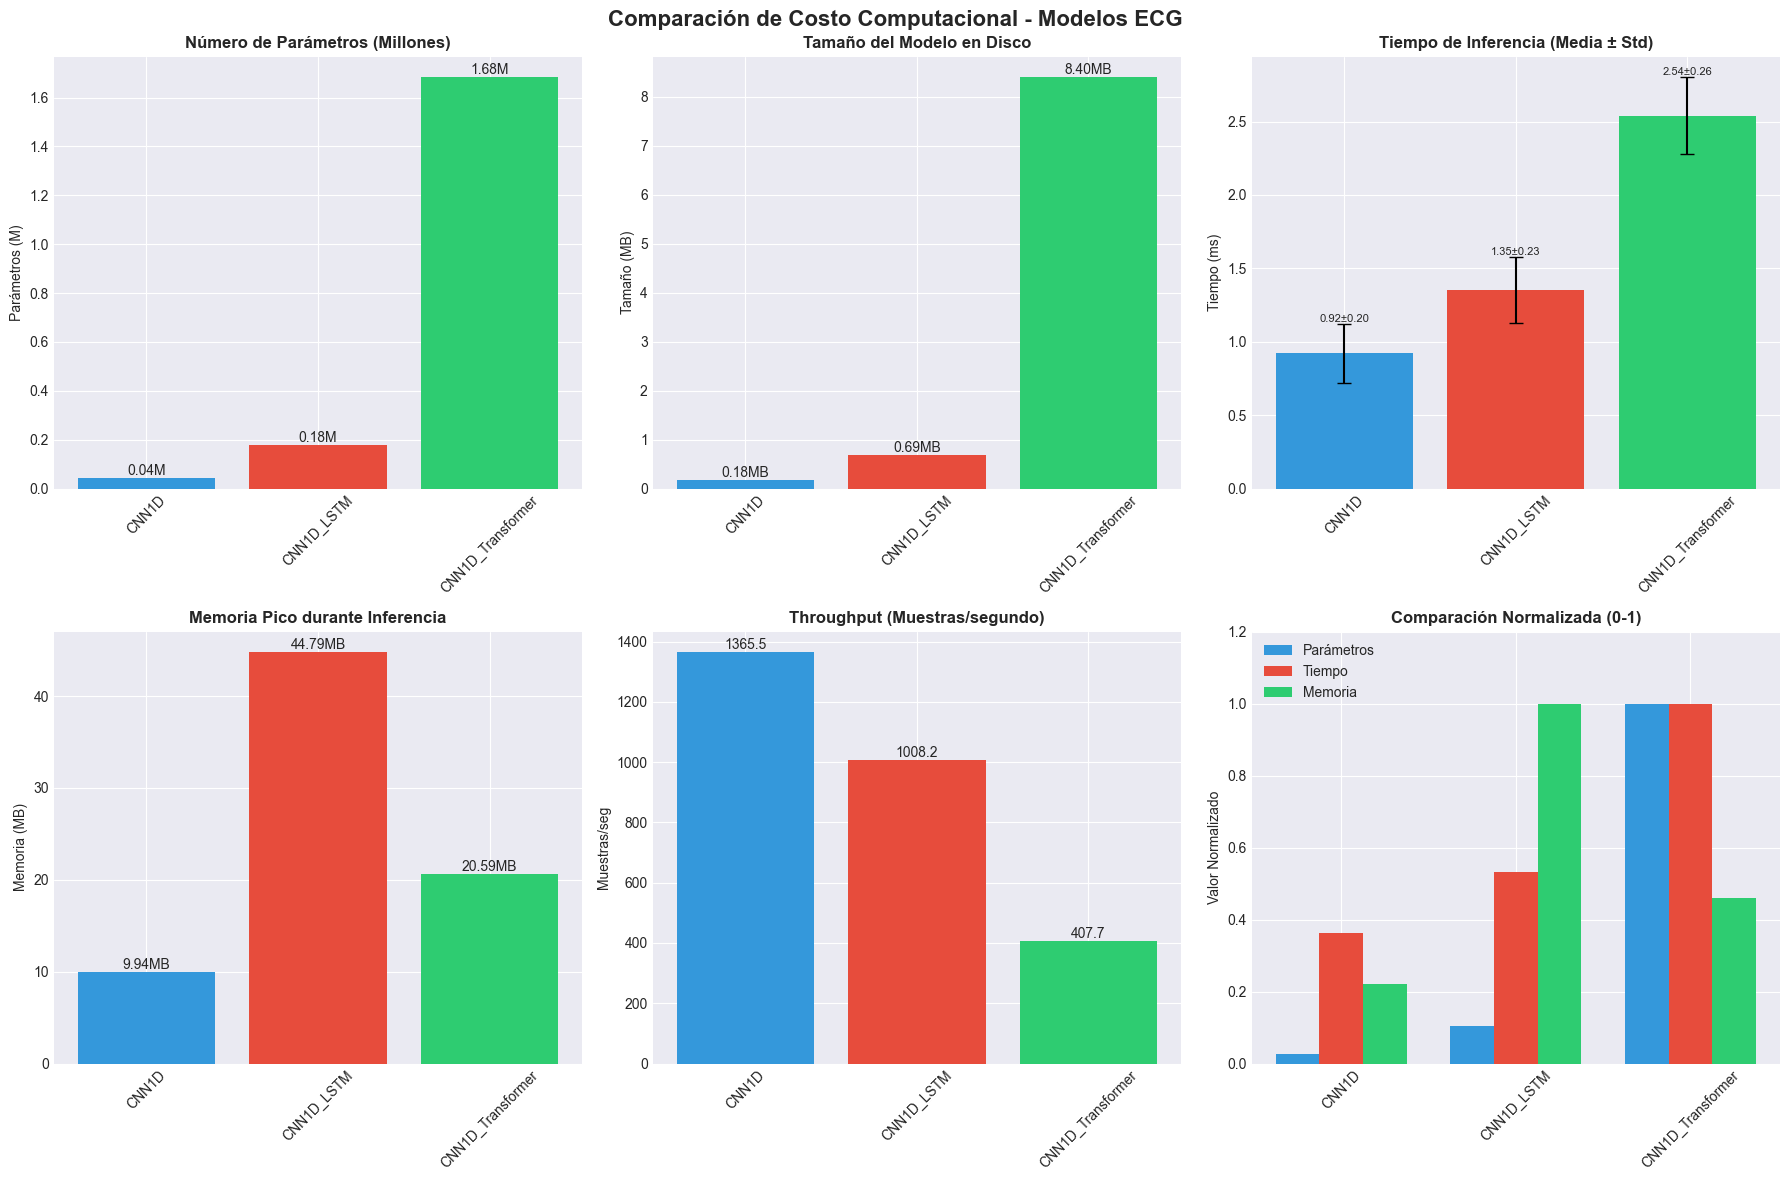

In [31]:
# Crear visualizaciones comparativas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Costo Computacional - Modelos ECG', fontsize=16, fontweight='bold')

models = df_metrics['model_name'].values

# 1. Parámetros
axes[0, 0].bar(models, df_metrics['total_params'] / 1e6, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 0].set_title('Número de Parámetros (Millones)', fontweight='bold')
axes[0, 0].set_ylabel('Parámetros (M)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_metrics['total_params'] / 1e6):
    axes[0, 0].text(i, v, f'{v:.2f}M', ha='center', va='bottom')

# 2. Tamaño del modelo
axes[0, 1].bar(models, df_metrics['model_size_mb'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0, 1].set_title('Tamaño del Modelo en Disco', fontweight='bold')
axes[0, 1].set_ylabel('Tamaño (MB)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_metrics['model_size_mb']):
    axes[0, 1].text(i, v, f'{v:.2f}MB', ha='center', va='bottom')

# 3. Tiempo de inferencia
axes[0, 2].bar(models, df_metrics['mean_time_ms'], yerr=df_metrics['std_time_ms'], 
                color=['#3498db', '#e74c3c', '#2ecc71'], capsize=5)
axes[0, 2].set_title('Tiempo de Inferencia (Media ± Std)', fontweight='bold')
axes[0, 2].set_ylabel('Tiempo (ms)')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, (m, s) in enumerate(zip(df_metrics['mean_time_ms'], df_metrics['std_time_ms'])):
    axes[0, 2].text(i, m + s, f'{m:.2f}±{s:.2f}', ha='center', va='bottom', fontsize=8)

# 4. Memoria pico
axes[1, 0].bar(models, df_metrics['peak_memory_mb'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 0].set_title('Memoria Pico durante Inferencia', fontweight='bold')
axes[1, 0].set_ylabel('Memoria (MB)')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_metrics['peak_memory_mb']):
    axes[1, 0].text(i, v, f'{v:.2f}MB', ha='center', va='bottom')

# 5. Throughput
axes[1, 1].bar(models, df_metrics['throughput_samples_per_sec'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 1].set_title('Throughput (Muestras/segundo)', fontweight='bold')
axes[1, 1].set_ylabel('Muestras/seg')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_metrics['throughput_samples_per_sec']):
    axes[1, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom')

# 6. Comparación relativa (normalizado)
normalized_params = df_metrics['total_params'] / df_metrics['total_params'].max()
normalized_time = df_metrics['mean_time_ms'] / df_metrics['mean_time_ms'].max()
normalized_memory = df_metrics['peak_memory_mb'] / df_metrics['peak_memory_mb'].max()

x = np.arange(len(models))
width = 0.25
axes[1, 2].bar(x - width, normalized_params, width, label='Parámetros', color='#3498db')
axes[1, 2].bar(x, normalized_time, width, label='Tiempo', color='#e74c3c')
axes[1, 2].bar(x + width, normalized_memory, width, label='Memoria', color='#2ecc71')
axes[1, 2].set_title('Comparación Normalizada (0-1)', fontweight='bold')
axes[1, 2].set_ylabel('Valor Normalizado')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models, rotation=45)
axes[1, 2].legend()
axes[1, 2].set_ylim(0, 1.2)

plt.tight_layout()
comparison_plot_path = OUTPUT_DIR / "computational_cost_comparison.png"
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {comparison_plot_path}")
plt.show()


In [32]:
# Guardar métricas en CSV
csv_path = OUTPUT_DIR / "computational_cost_metrics.csv"
df_metrics.to_csv(csv_path, index=False)
print(f"✓ Métricas guardadas en: {csv_path}")

# Crear tabla resumen más detallada
print("\n" + "="*100)
print("📋 TABLA DETALLADA DE MÉTRICAS")
print("="*100)
print(df_metrics.to_string(index=False))


✓ Métricas guardadas en: s:\Proyecto final\Books\computational_cost_comparison\computational_cost_metrics.csv

📋 TABLA DETALLADA DE MÉTRICAS
       model_name device input_shape  batch_size  total_params  trainable_params  non_trainable_params  model_size_mb  mean_time_ms  std_time_ms  min_time_ms  max_time_ms  median_time_ms  p95_time_ms  p99_time_ms  peak_memory_mb  model_memory_mb    flops  flops_g  throughput_samples_per_sec  samples_processed  duration_sec                                                training_config                       date
            CNN1D   cuda   (3, 2000)           1         44481             44481                     0       0.180224      0.921196     0.201597       0.7085       1.6763         0.89715     1.297710     1.586210        9.935547         0.169682   266886 0.000267                 1365.549229               6828      5.000186  {'batch_size': 128, 'learning_rate': 0.001, 'num_epochs': 30} 2025-11-24 22:28:39.331290
       CNN1D_LSTM   cuda   (3

## 7. 📊 Registro en MLflow


In [33]:
# Configuración de MLflow
EXPERIMENT_NAME = "ECG_Models_Computational_Cost_Comparison"
MLFLOW_TRACKING_URI = None  # None = usa directorio local

def setup_mlflow(experiment_name: str, tracking_uri: Optional[str] = None) -> str:
    """Configura MLflow y crea/obtiene el experimento."""
    try:
        if tracking_uri is not None:
            mlflow.set_tracking_uri(tracking_uri)
        else:
            # Usar SQLite local
            tracking_db = (PARENT_DIR / "mlflow.db").resolve()
            mlflow.set_tracking_uri(f"sqlite:///{tracking_db.as_posix()}")
            print(f"✓ MLflow tracking URI: sqlite:///{tracking_db.as_posix()}")
        
        # Crear o obtener experimento
        try:
            experiment = mlflow.get_experiment_by_name(experiment_name)
            if experiment is None:
                artifact_root = (PARENT_DIR / "mlflow_artifacts").resolve()
                experiment_id = mlflow.create_experiment(experiment_name, artifact_location=artifact_root.as_uri())
                print(f"✓ Experimento MLflow creado: {experiment_name} (ID: {experiment_id})")
            else:
                experiment_id = experiment.experiment_id
                print(f"✓ Experimento MLflow existente: {experiment_name} (ID: {experiment_id})")
        except Exception:
            experiment_id = mlflow.set_experiment(experiment_name)
            print(f"✓ Experimento MLflow configurado: {experiment_name}")
        
        return experiment_id
    except Exception as e:
        print(f"⚠ Error al configurar MLflow: {e}")
        experiment_id = mlflow.set_experiment(experiment_name)
        return experiment_id

# Configurar MLflow
experiment_id = setup_mlflow(EXPERIMENT_NAME, MLFLOW_TRACKING_URI)

# Registrar métricas en MLflow
print("\n📊 Registrando métricas en MLflow...")

with mlflow.start_run(experiment_id=experiment_id, run_name="computational_cost_comparison"):
    # Log parámetros generales
    mlflow.log_params({
        "input_shape": str(INPUT_SHAPE),
        "batch_size": BATCH_SIZE,
        "device": str(device),
        "num_models": len(loaded_models),
    })
    
    # Log métricas para cada modelo
    for idx, metrics in enumerate(all_metrics):
        model_name = metrics["model_name"]
        
        # Métricas principales
        mlflow.log_metrics({
            f"{model_name}_total_params": metrics["total_params"],
            f"{model_name}_total_params_M": metrics["total_params"] / 1e6,
            f"{model_name}_model_size_mb": metrics.get("model_size_mb", 0),
            f"{model_name}_mean_inference_time_ms": metrics["mean_time_ms"],
            f"{model_name}_std_inference_time_ms": metrics["std_time_ms"],
            f"{model_name}_min_inference_time_ms": metrics["min_time_ms"],
            f"{model_name}_max_inference_time_ms": metrics["max_time_ms"],
            f"{model_name}_median_inference_time_ms": metrics["median_time_ms"],
            f"{model_name}_p95_inference_time_ms": metrics["p95_time_ms"],
            f"{model_name}_p99_inference_time_ms": metrics["p99_time_ms"],
            f"{model_name}_peak_memory_mb": metrics["peak_memory_mb"],
            f"{model_name}_model_memory_mb": metrics["model_memory_mb"],
            f"{model_name}_throughput_samples_per_sec": metrics["throughput_samples_per_sec"],
        }, step=idx)
        
        # FLOPs si está disponible
        if metrics.get("flops") is not None:
            mlflow.log_metrics({
                f"{model_name}_flops": metrics["flops"],
                f"{model_name}_flops_G": metrics["flops_g"],
            }, step=idx)
    
    # Log artefactos
    mlflow.log_artifact(str(csv_path), artifact_path="metrics")
    mlflow.log_artifact(str(comparison_plot_path), artifact_path="plots")
    
    # Log tabla comparativa como artefacto de texto
    summary_text = f"""
# Resumen de Comparación de Costo Computacional

## Modelos Evaluados
{', '.join([m['model_name'] for m in all_metrics])}

## Métricas Principales

"""
    for metrics in all_metrics:
        summary_text += f"""
### {metrics['model_name']}
- **Parámetros**: {metrics['total_params']:,} ({metrics['total_params']/1e6:.2f}M)
- **Tamaño del modelo**: {metrics.get('model_size_mb', 0):.2f} MB
- **Tiempo de inferencia**: {metrics['mean_time_ms']:.3f} ± {metrics['std_time_ms']:.3f} ms
- **Memoria pico**: {metrics['peak_memory_mb']:.2f} MB
- **Throughput**: {metrics['throughput_samples_per_sec']:.2f} muestras/segundo
"""
        if metrics.get('flops') is not None:
            summary_text += f"- **FLOPs**: {metrics['flops']/1e9:.2f}G\n"
    
    summary_path = OUTPUT_DIR / "summary.txt"
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary_text)
    mlflow.log_artifact(str(summary_path), artifact_path="summary")
    
    print("✓ Métricas registradas en MLflow")
    print(f"  Experimento: {EXPERIMENT_NAME}")
    print(f"  Run: computational_cost_comparison")


✓ MLflow tracking URI: sqlite:///S:/Proyecto final/Books/mlflow.db
✓ Experimento MLflow existente: ECG_Models_Computational_Cost_Comparison (ID: 1)

📊 Registrando métricas en MLflow...
✓ Métricas registradas en MLflow
  Experimento: ECG_Models_Computational_Cost_Comparison
  Run: computational_cost_comparison


In [34]:
# Análisis comparativo
print("\n" + "="*80)
print("🔍 ANÁLISIS COMPARATIVO")
print("="*80)

# Modelo más ligero
lightest = df_metrics.loc[df_metrics['total_params'].idxmin()]
print(f"\n🏆 Modelo más ligero (menos parámetros): {lightest['model_name']}")
print(f"   - Parámetros: {lightest['total_params']:,} ({lightest['total_params']/1e6:.2f}M)")
print(f"   - Tamaño: {lightest['model_size_mb']:.2f} MB")

# Modelo más rápido
fastest = df_metrics.loc[df_metrics['mean_time_ms'].idxmin()]
print(f"\n⚡ Modelo más rápido: {fastest['model_name']}")
print(f"   - Tiempo de inferencia: {fastest['mean_time_ms']:.3f} ms")
print(f"   - Throughput: {fastest['throughput_samples_per_sec']:.2f} muestras/seg")

# Modelo más eficiente en memoria
most_efficient_memory = df_metrics.loc[df_metrics['peak_memory_mb'].idxmin()]
print(f"\n💾 Modelo más eficiente en memoria: {most_efficient_memory['model_name']}")
print(f"   - Memoria pico: {most_efficient_memory['peak_memory_mb']:.2f} MB")

# Ratio eficiencia/rendimiento
df_metrics['efficiency_score'] = (
    df_metrics['throughput_samples_per_sec'] / 
    (df_metrics['total_params'] / 1e6)
)
most_efficient = df_metrics.loc[df_metrics['efficiency_score'].idxmax()]
print(f"\n🎯 Modelo más eficiente (throughput/parámetros): {most_efficient['model_name']}")
print(f"   - Score de eficiencia: {most_efficient['efficiency_score']:.4f}")
print(f"   - Throughput: {most_efficient['throughput_samples_per_sec']:.2f} muestras/seg")
print(f"   - Parámetros: {most_efficient['total_params']/1e6:.2f}M")

print("\n" + "="*80)
print("✅ Comparación completada y registrada en MLflow")
print("="*80)



🔍 ANÁLISIS COMPARATIVO

🏆 Modelo más ligero (menos parámetros): CNN1D
   - Parámetros: 44,481 (0.04M)
   - Tamaño: 0.18 MB

⚡ Modelo más rápido: CNN1D
   - Tiempo de inferencia: 0.921 ms
   - Throughput: 1365.55 muestras/seg

💾 Modelo más eficiente en memoria: CNN1D
   - Memoria pico: 9.94 MB

🎯 Modelo más eficiente (throughput/parámetros): CNN1D
   - Score de eficiencia: 30699.6072
   - Throughput: 1365.55 muestras/seg
   - Parámetros: 0.04M

✅ Comparación completada y registrada en MLflow
